## Импортируем модули

In [44]:
from pandas import Series
import pandas as pd
import pandas_profiling
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.impute import KNNImputer

from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

import os

In [45]:
RANDOM_SEED = 42
!pip freeze > requirements.txt
CURRENT_DATE = pd.to_datetime('14/09/2020')

pd.options.display.float_format = '{:.4f}'.format

pd.options.mode.chained_assignment = None

## Статистические функции

In [46]:
def plot_confusion_matrix(y_true, y_pred, font_scale, classes,
                          normalize=False,
                          title=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    list_of_labels = [['TP', 'FP'], ['FN', 'TN']]

    if not title:
        if normalize:
            title = 'Нормализованная матрица ошибок'
        else:
            title = 'Матрица ошибок без нормализации'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    cm[0, 0], cm[1, 1] = cm[1, 1], cm[0, 0]

    # # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.style.use('seaborn-paper')
    cmap = plt.cm.Blues
    color_text = plt.get_cmap('PuBu')(0.85)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.grid(False)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries

           title=title)
    ax.title.set_fontsize(15)
    ax.set_ylabel('Предсказанные значения', fontsize=14, color=color_text)
    ax.set_xlabel('Целевая переменная', fontsize=14, color=color_text)
    ax.set_xticklabels(classes, fontsize=12, color='black')
    ax.set_yticklabels(classes, fontsize=12, color='black')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, list_of_labels[i][j] + '\n' + format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


def confusion_matrix_f(columns, d_y, d_y_pred, font_scale=1, normalize=False):
    class_names = np.array(columns, dtype='U10')
    # Plot non-normalized confusion matrix
    plot_confusion_matrix(d_y, d_y_pred, font_scale, classes=class_names,
                          title='Матрица ошибок без нормализации')

    # Plot normalized confusion matrix
    if normalize:
        plot_confusion_matrix(d_y, d_y_pred, font_scale, classes=class_names, normalize=True,
                              title='Нормализованная матрица ошибок')

    plt.show()
    return


def PR_curve_with_area(d_y_true, d_y_pred_prob, font_scale=1):
    plt.style.use('seaborn-paper')
    sns.set(font_scale=font_scale)
    # sns.set_color_codes("muted")

    plt.figure(figsize=(8, 6))
    precision, recall, thresholds = precision_recall_curve(d_y_true, d_y_pred_prob, pos_label=1)
    prc_auc_score_f = auc(recall, precision)
    plt.plot(precision, recall, lw=3, label='площадь под PR кривой = %0.3f)' % prc_auc_score_f)

    plt.xlim([-.05, 1.0])
    plt.ylim([-.05, 1.05])
    plt.xlabel('Точность \n Precision = TP/(TP+FP)')
    plt.ylabel('Полнота \n Recall = TP/P')
    plt.title('Precision-Recall кривая')
    plt.legend(loc="upper right")
    plt.show()
    return


def vis_cross_val_score(d_name_metric, d_vec, d_value_metric, font_scale):
    num_folds = len(d_vec['train_score'])
    avg_metric_train, std_metric_train = d_vec['train_score'].mean(), d_vec['train_score'].std()
    avg_metric_test, std_metric_test = d_vec['test_score'].mean(), d_vec['test_score'].std()

    plt.style.use('seaborn-paper')
    sns.set(font_scale=font_scale)
    color_text = plt.get_cmap('PuBu')(0.85)

    plt.figure(figsize=(12, 6))
    plt.plot(d_vec['train_score'], label='тренировочные значения', marker='.', color='darkblue')
    plt.plot([0, num_folds - 1], [avg_metric_train, avg_metric_train], color='blue',
             label='среднее трен. значений ', marker='.', lw=2, ls='--')

    plt.plot(d_vec['test_score'], label='тестовые значения', marker='.', color='red')
    plt.plot([0, num_folds - 1], [avg_metric_test, avg_metric_test], color='lightcoral',
             label='среднее тест. значений ', marker='.', lw=2, ls='--')

    plt.plot([0, num_folds - 1], [d_value_metric, d_value_metric], color='grey',
             label='значение метрики до CV', marker='.', lw=3)

    # plt.xlim([1, num_folds])
    y_max = max(avg_metric_train, avg_metric_test) + 1.5 * max(std_metric_train, std_metric_test)
    y_min = min(avg_metric_train, avg_metric_test) - 3 * max(std_metric_train, std_metric_test)
    plt.ylim([y_min, y_max])
    plt.xlabel('номер фолда', fontsize=15, color=color_text)
    plt.ylabel(d_name_metric, fontsize=15, color=color_text)
    plt.title(f'Кросс-валидация по метрике {d_name_metric} на {num_folds} фолдах',
              color=color_text, fontsize=17)
    plt.legend(loc="lower right", fontsize=11)
    y_min_text = y_min + 0.5 * max(std_metric_train, std_metric_test)
    plt.text(0, y_min_text,
             f'{d_name_metric} на трейне = {round(avg_metric_train, 3)} +/- '
             f'{round(std_metric_train, 3)} \n{d_name_metric} на тесте    = {round(avg_metric_test, 3)} +/- '
             f'{round(std_metric_test, 3)} \n{d_name_metric} до CV        = {round(d_value_metric, 3)}',
             fontsize=15)
    plt.show()
    return


def model_coef(d_columns, d_model_coef_0):
    temp_dict = {}
    temp_dict['имя признака'] = d_columns
    temp_dict['коэффициент модели'] = d_model_coef_0
    temp_dict['модуль коэф'] = abs(temp_dict['коэффициент модели'])
    temp_df = pd.DataFrame.from_dict(temp_dict, orient='columns')
    temp_df = temp_df.sort_values(by='модуль коэф', ascending=False)
    temp_df.reset_index(drop=True, inplace=True)

    return temp_df.loc[:, ['имя признака', 'коэффициент модели']]

def ROC_curve_with_area(d_y_true, d_y_pred_prob, font_scale):
    roc_auc_score_f = roc_auc_score(d_y_true, d_y_pred_prob)

    plt.style.use('seaborn-paper')
    sns.set(font_scale=font_scale)
    # sns.set_color_codes("muted")

    plt.figure(figsize=(8, 6))
    fpr, tpr, thresholds = roc_curve(d_y_true, d_y_pred_prob, pos_label=1)

    plt.plot(fpr, tpr, lw=3, label='площадь под ROC кривой = %0.3f)' % roc_auc_score_f)
    plt.plot([0, 1], [0, 1], color='grey')
    plt.xlim([-.05, 1.0])
    plt.ylim([-.05, 1.05])
    plt.xlabel('Ложно классифицированные \n False Positive Rate (FPR)')
    plt.ylabel('Верно классифицированные \n True Positive Rate (TPR)')
    plt.title('ROC кривая')
    plt.legend(loc="lower right")
    plt.show()
    return

## Функции для визуализации

In [47]:
def viz_counter_bar(df, column, title, max_values=0, sort_by_index=False):
    """
    Визуализация количества значений в ДФ, Value_counts, 
    горизонтальные столбцы
    df - датафрейм, column - столбец, title - подпись
    max_values - максимальное количество значений для отображения, 0 - все
    sort_by_index - сортирует по индексам, а не значен#иям
    dollars - отображает подписи с $$ для price_range
    """
    if max_values > 0:
        col_values = df[column].value_counts().nlargest(
            max_values).sort_values(ascending=True)
    else:
        col_values = df[column].value_counts(ascending=True)
    
    if sort_by_index: 
        col_values = col_values.sort_index()
    
    fig, ax = plt.subplots()
    plt.rcParams['figure.figsize'] = (8, 8)
    plt.figure 
    ax = col_values.plot(kind='bar', title=title)
    for i, v in enumerate(col_values):
        plt.text(i, v+(col_values.max()/100), ""+str(v), ha='center', rotation = 'horizontal')
    
    plt.xticks(rotation=0)
    
    plt.show()

    
def viz_counter_barh(df, column, title, max_values=0):
    """
    Визуализация количества значений в ДФ, Value_counts, 
    горизонтальные столбцы
    df - датафрейм, column - столбец, title - подпись
    max_values - максимальное количество значений для отображения, 0 - все
    """
    if max_values > 0:
        col_values = df[column].value_counts().nlargest(
            max_values).sort_values(ascending=True)
    else:
        col_values = df[column].value_counts(ascending=True)
    
    fig, ax = plt.subplots()
    plt.rcParams['figure.figsize'] = (8, 10)
    plt.figure 
    ax = col_values.plot(kind='barh', title=title)
    ax.set_xlim(0, col_values.max()*1.15)
    
    for i, v in enumerate(col_values):
        plt.text(v, i, " "+str(v), va='center')
    
    plt.show()

def iqr_test(column, lim_a, lim_b, bins, hist=True):
    """
    Функция определения медианы, квантилей 25%/75% и 
    границы выбросов для данного сталбцы 
    lim_a lim_b - пределы для построенния гистограммы
    """
    median = df[column].median()
    IQR = df[column].quantile(0.75) - df[column].quantile(0.25)
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25), 
          '75-й перцентиль: {},'.format(perc75), 
          "IQR: {}, ".format(IQR),
          "Границы выбросов: [{f}, {l}]."
          .format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    if hist:
        df[column].loc[df[column].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].\
        hist(bins=bins, range=(lim_a, lim_b), label='IQR')


def print_metrics():
    print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
    print('Precision: %.4f' % precision_score(y_test, y_pred))
    print('Recall: %.4f' % recall_score(y_test, y_pred))
    print('F1: %.4f' % f1_score(y_test, y_pred))

## Импортируем данные

In [48]:
# этот блок закомментирован так как используется только локальной машине
from importlib import reload
print(os.listdir('./data'))
PATH_to_file = './data/'

['sample_submission.csv', 'test.csv', 'train.csv']


In [49]:
df_train = pd.read_csv(PATH_to_file+'train.csv')
df_test = pd.read_csv(PATH_to_file+'test.csv')
pd.set_option('display.max_columns', None)
print('Размерность тренировочного датасета: ', df_train.shape)
display(df_train.head(2))
print('Размерность тестового датасета: ', df_test.shape)
display(df_test.head(2))

Размерность тренировочного датасета:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.0088,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.5323,3,50,2,3,19000,4,1,N,0


Размерность тестового датасета:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.2719,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.5050,2,50,1,2,5000,4,3,N


Объеденяем два датафрейма в один, помечаем где тренировочный, а где тестовый

In [50]:
df_train['Train'] = 1  # тренировочный
df_test['Train'] = 0 # тестовый

df = df_train.append(df_test, sort=False).reset_index(drop=True) 
#!Обратите внимание объединение датасетов является потенциальной опасностью для даталиков

# Разведывательный анализ данных (EDA)

In [51]:
# pandas_profiling закооментирован так как некорректно отображается на kaggle
#pandas_profiling.ProfileReport(df)

In [52]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
client_id,110148.0000,NaN,NaN,NaN,55074.5000,31797.1331,1.0000,27537.7500,55074.5000,82611.2500,110148.0000
app_date,110148,120,18MAR2014,1491,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,109670,5,SCH,57998,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,110148,2,F,61836,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,110148.0000,NaN,NaN,NaN,39.2494,11.5181,21.0000,30.0000,37.0000,48.0000,72.0000
car,110148,2,N,74290,NaN,NaN,NaN,NaN,NaN,NaN,NaN
car_type,110148,2,N,89140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
decline_app_cnt,110148.0000,NaN,NaN,NaN,0.2732,0.7991,0.0000,0.0000,0.0000,0.0000,33.0000
good_work,110148.0000,NaN,NaN,NaN,0.1655,0.3716,0.0000,0.0000,0.0000,0.0000,1.0000
score_bki,110148.0000,NaN,NaN,NaN,-1.9045,0.4994,-3.6246,-2.2604,-1.9208,-1.5679,0.1998


Всего в тренировочной выборке 73799 клиентов, в тестовой 36349. Суммарно 110148. Всего 20 переменных: 1 - временной ряд, 7 - бинарных, среди которых целевая переменная (**default**) и добавленный столбец **Train**. 6 - категориальных, 6 - числовых, среди которых id клиента, который не несет полезных данных для исследования (а нужен только для submit) 


### Описание столбцов

**client_id** - идентификатор клиента  
**education** - уровень образования  
**sex** - пол заемщика  
**age** - возраст заемщика  
**car** - флаг наличия автомобиля  
**car_type** - флаг наличия иномарки  
**decline_app_cnt** - количество отказанных прошлых заявок  
**good_work** - флаг наличия "хорошей" работы  
**bki_request_cnt** - количество запросов в БКИ  
**home_address** - категоризатор домашнего адреса  
**work_addreess** - категоризатор рабочего адреса  
**income** - доход заемщика  
**foreign_passport** - наличие загранпаспорта  
**sna** - свзяь заемщика с клиентами банка  
**first_time** - давность наличия информации из БКИ  
**region_rating** - рейтинг региона  
**app_date** - дата подачи заявки  
**default** - наличие дефолта  

### Количество пропусков

In [53]:
df.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
Train                   0
dtype: int64

Пропуски только в столбце **education** заполним при их позже.

## Education - уровень образования  
* SCH - школа  
* UGR - кандидат в бакалавры  
* GRD - бакалавр
* PRG - магистр  
* ACD - академик


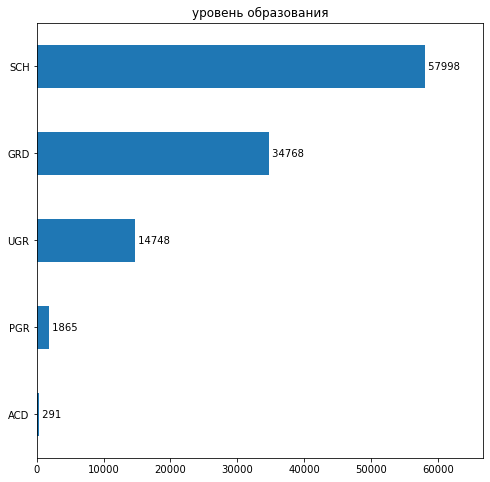

In [54]:
viz_counter_barh(df, 'education', 'уровень образования')

Большинство заемщиков - люди только со школьным образованием. Людей с высшим образованием (бакалавры, кандидаты в бакалавр и магистры ) - почти половина. Академиков меньше 1%. Также у нас есть пропуски в данных (478). Заполним их при помощи KNN и приведем столбец к числовому виду.

In [55]:
train_knn = df[['education', 'good_work', 'age', 'home_address', 'work_address']]
imputer = KNNImputer(n_neighbors = 9)

# создаем словарь из списка типов образования (0 -самое популярной, школьное и т.д.)
edu = df.education.value_counts().index.to_list() 
edu_dict = {}
for counter, edu_word in enumerate(edu):
    edu_dict[edu_word] = counter
    
train_knn['education'].replace(edu_dict, inplace=True)

In [56]:
df_fill = imputer.fit_transform(train_knn)
df.loc[:, 'education'] = np.round(df_fill.T[0],0)

## sex - пол заемщика  
* M - мужчины  
* F - женщины

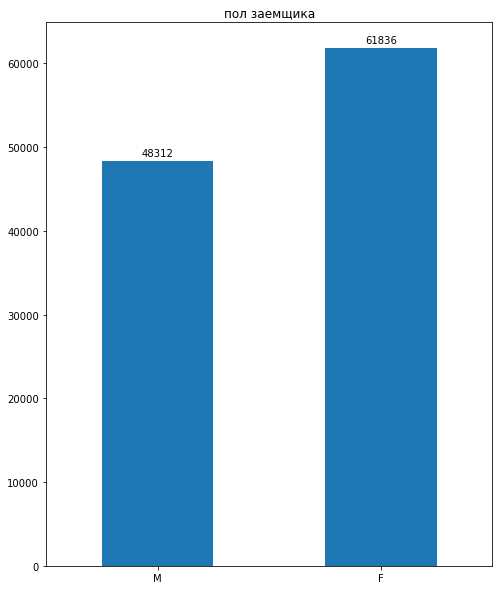

In [57]:
viz_counter_bar(df, 'sex', 'пол заемщика')

Женщин немного больше, но не критично.

## age - возраст заемщика  

25-й перцентиль: 30.0, 75-й перцентиль: 48.0, IQR: 18.0,  Границы выбросов: [3.0, 75.0].


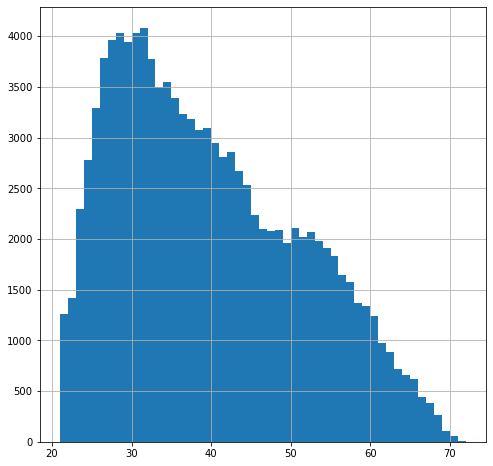

In [58]:
iqr_test('age', 21, 72, 51)

Минимальный возраст - 21 год, максимальный - 72 года. Средний около 37 лет. Выбросов нет. Распредение логнормлаьное. Прологарифмируем данный столбец

In [59]:
df['age'] = np.log(df['age'] + 1)

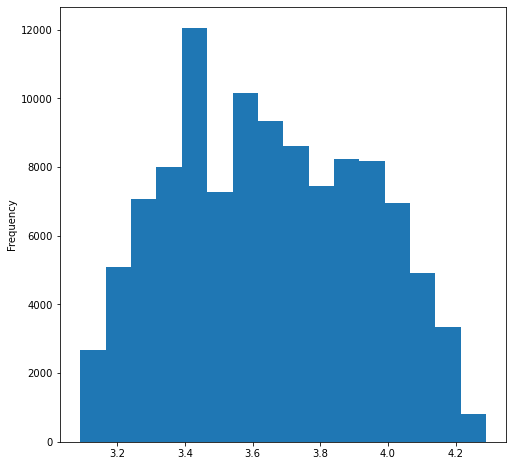

In [60]:
df['age'].plot.hist(bins=16);

После логарифмирования выглядит лучше

## сar - наличие автомобиля

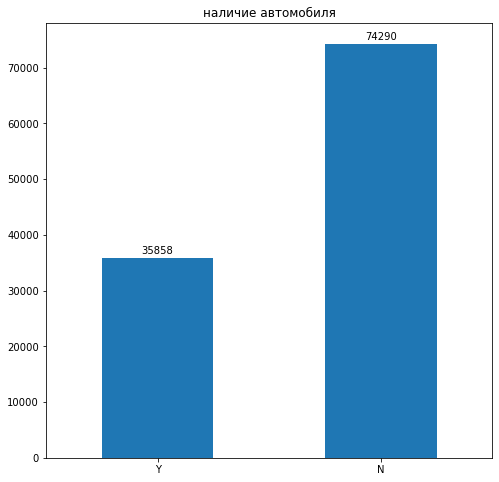

In [61]:
viz_counter_bar(df, 'car', 'наличие автомобиля')

У большинства заемщиков нет автомобиля

## сar_type - наличие иномарки

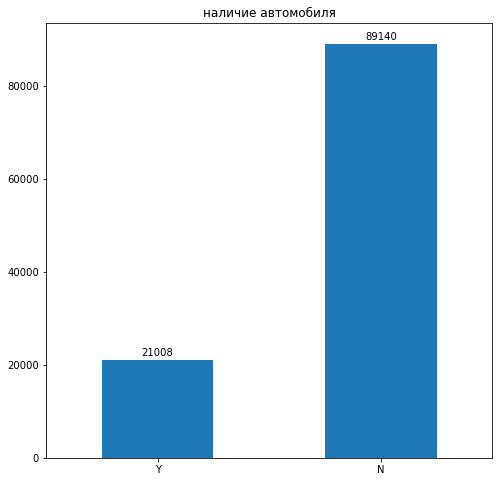

In [62]:
viz_counter_bar(df, 'car_type', 'наличие автомобиля')

Из 23967 заемщиков-автомодилистов у 14008 есть иномарка.  
Возможно стоит из двух столбцов сделать один, из бинарного категориальным. 0 - отсутвие авто, 1 - автомобиль (не иномарка), 2 - автомобиль (иномарка)  

## decline_app_cnt - количество отказанных прошлых заявок

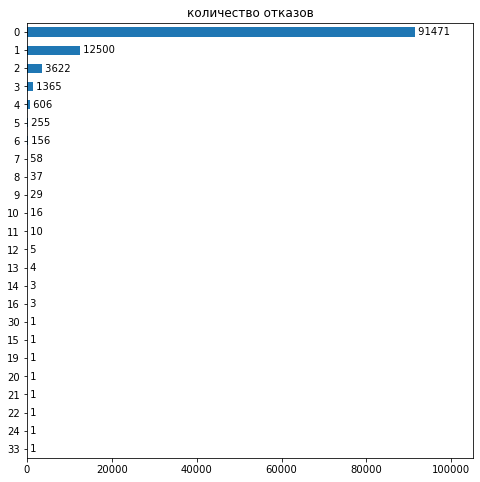

In [63]:
viz_counter_barh(df, 'decline_app_cnt', 'количество отказов')

Распределение логнормальное, очень много единичных случаев с большим колиством заявок. Если просуммировать всё количество заявок больше 4 , то выйдет около 1 процента от количества всех заемщиков. Можно поступить следующими методами. 
1 Прологарифмировать, но это не сильно поможет, т.к. количество по 1 заявке.  
2 Считать как выброс и удалить. данных не так много, но модель может получиться не полностью обученной.  
3 Заменить все значения выше 5 на 5. Ограничим количество заявок.

In [64]:
#df.loc[df['decline_app_cnt']>5, 'decline_app_cnt'] = 5

In [65]:
df['decline_app_cnt'] = np.log(df['decline_app_cnt'] + 1)

In [66]:
df.decline_app_cnt

0        0.0000
1        0.0000
2        1.0986
3        0.0000
4        0.0000
          ...  
110143   0.6931
110144   0.0000
110145   1.0986
110146   0.6931
110147   0.0000
Name: decline_app_cnt, Length: 110148, dtype: float64

## good_work - наличие хорошей работы

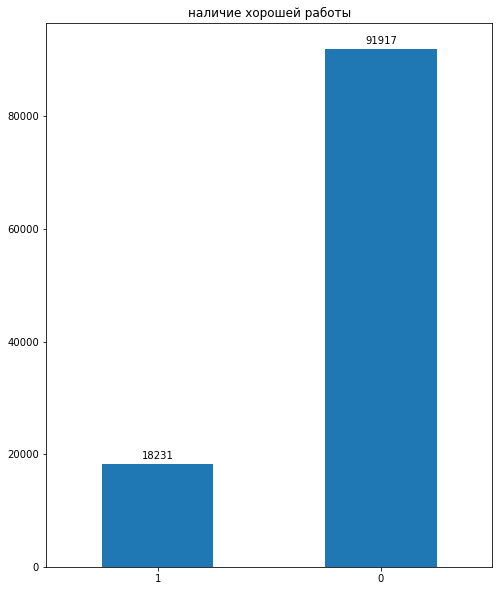

In [67]:
viz_counter_bar(df, 'good_work', 'наличие хорошей работы')

Хорошая работы только примерно у каждого пятого заемщика.

## bki_request_cnt - количество запросов в БКИ

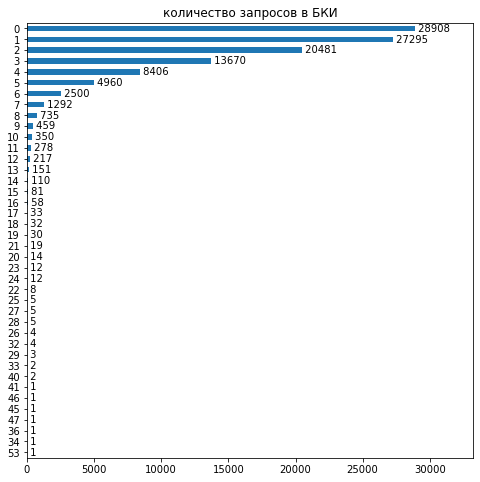

In [68]:
viz_counter_barh(df, 'bki_request_cnt', 'количество запросов в БКИ')

Распределение логнормальное, посмотрим на выбросы. 

In [69]:
iqr_test('bki_request_cnt', 0, 55, 50, hist=False)

25-й перцентиль: 0.0, 75-й перцентиль: 3.0, IQR: 3.0,  Границы выбросов: [-4.5, 7.5].


Ситуация похожая с **decline_app_cnt** , есть несколько заемщиков с большим количеством запросов. Но суммарно их меньше 1 процента. Пока просто прологорифмируем

In [70]:
df['bki_request_cnt'] = np.log(df['bki_request_cnt'] + 1)

## home_address - домашний адрес

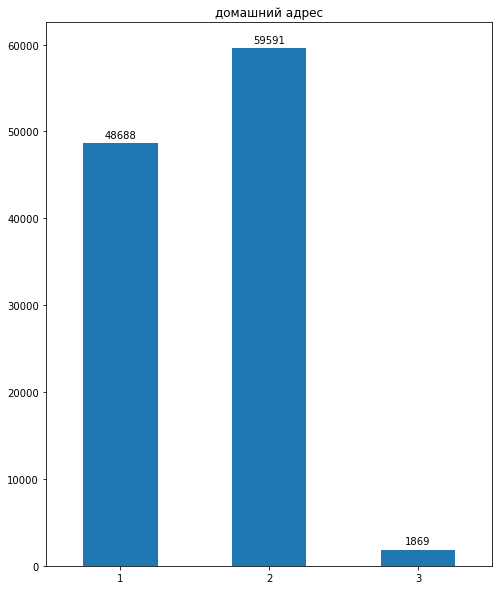

In [71]:
viz_counter_bar(df, 'home_address', 'домашний адрес', sort_by_index=True)

В основном все заемщики проживают в двух районах. В третьем примерно 2% от общего количества

## work_address - категоризатор рабочего адреса

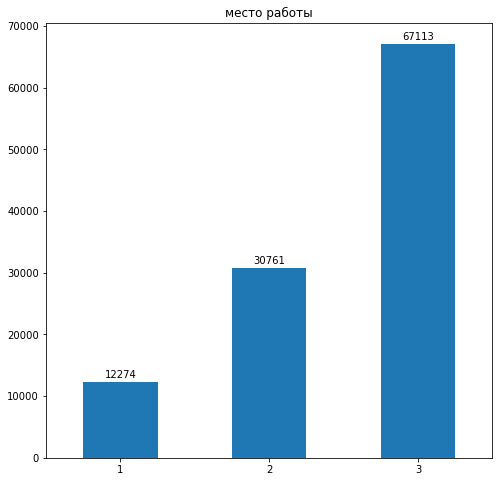

In [72]:
viz_counter_bar(df, 'work_address', 'место работы', sort_by_index=True)

Больше половины работает в третьем районе, меньше всего в первом.

## income - доход заемщика

25-й перцентиль: 20000.0, 75-й перцентиль: 48000.0, IQR: 28000.0,  Границы выбросов: [-22000.0, 90000.0].


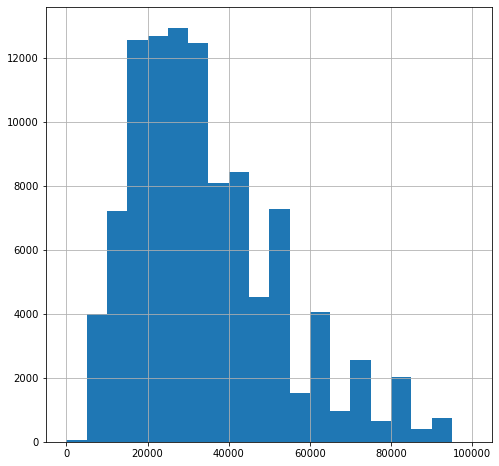

In [73]:
iqr_test('income', 0, 100000, 20)

Распределение логнормальное, возьмем логарифм. Но перед этим посмотрим распределение доходов по районам проживания и работе

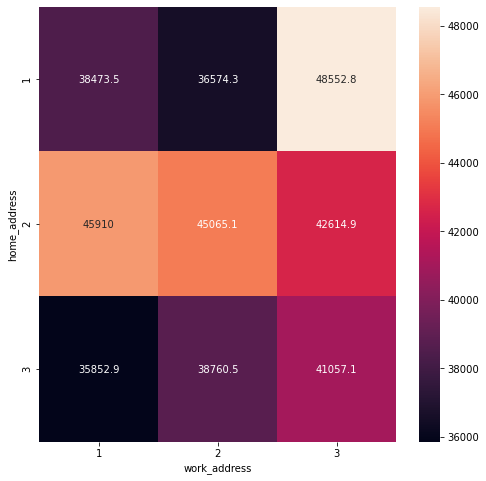

In [74]:
incomes = df.groupby(['home_address', 'work_address'])['income'].mean()
sns.heatmap(incomes.unstack(), annot=True, fmt='g');

Из карты получается следующая ситуация:  
* Доход в 3м районе работы чуть выше чем в других. 
* Доход во втором районе жительства тоже выше чем в остальных.  
* Самый большой доход в паре work_add = 3, home_addr = 1  
Одна из возможных ситуаций.  
1 - это центральная часть города для домашнего адреса, 3 - пригород  или 1,2,3 - категории типа производство, офисные и пр.  
1 - спальные районы для домашнего адреса, 3 - центральная часть 

Посмотрим на наличие автомобилей

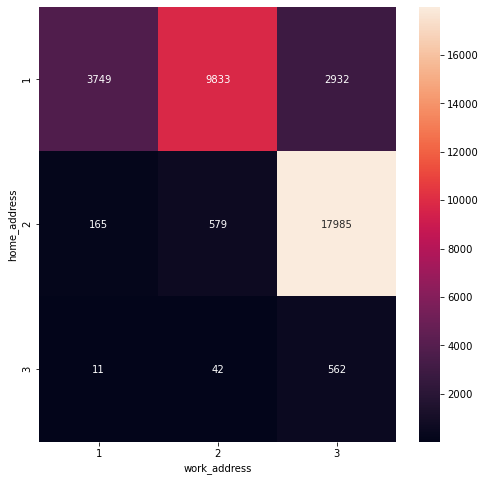

In [75]:
cars = df[df.car=='Y'].groupby(['home_address', 'work_address'])['car'].count()
sns.heatmap(cars.unstack(), annot=True, fmt='g');

Интересно, но те кто живет во втором районе и работает в третьем районе - автомобиль нужен гораздо больше чем другим.

In [76]:
# логарифмируем income
df['income'] = np.log(df['income'] + 1)

## foreign_passport - наличие загранпаспорта

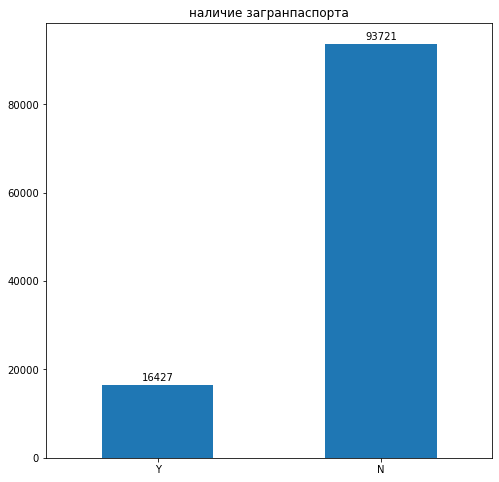

In [77]:
viz_counter_bar(df, 'foreign_passport', 'наличие загранпаспорта')

## sna - связь заемщика с клиентами банка

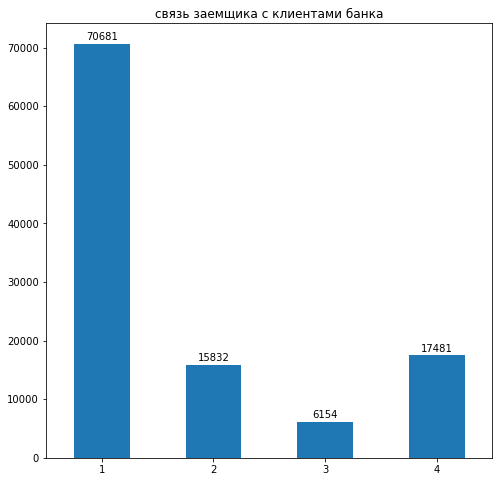

In [78]:
viz_counter_bar(df, 'sna', 'связь заемщика с клиентами банка', sort_by_index=True)

## first_time - давность наличия информации о заемщике

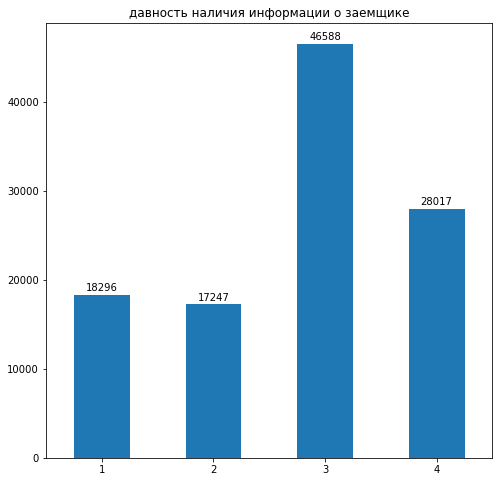

In [79]:
viz_counter_bar(df, 'first_time', 'давность наличия информации о заемщике', sort_by_index=True)

Распределение ближе к нормальному. 

## score_bki - скоринговый балл по данным из БКИ

25-й перцентиль: -2.2604336700000003, 75-й перцентиль: -1.5678881525, IQR: 0.6925455175000004,  Границы выбросов: [-3.299251946250001, -0.5290698762499992].


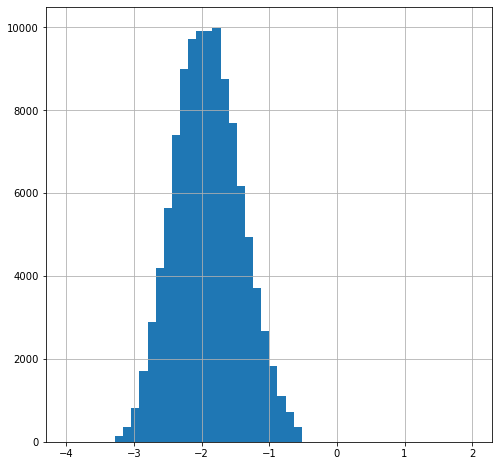

In [80]:
iqr_test('score_bki', -4, 2, 50)

Распределение нормальное, выбросов нет

## region_rating - рейтинг региона

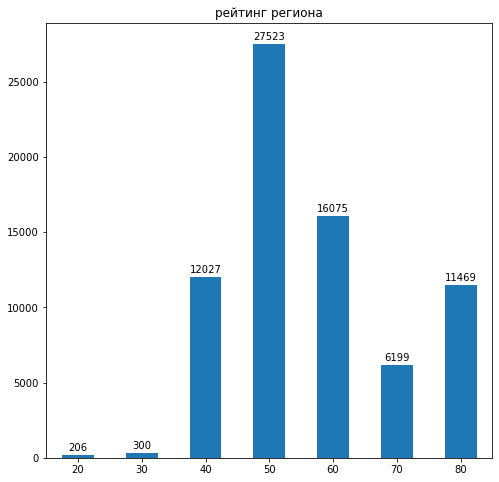

In [81]:
viz_counter_bar(df[df.Train==1], 'region_rating', 'рейтинг региона', sort_by_index=True)

In [82]:
iqr_test('region_rating', 10, 90, 50, hist=False)

25-й перцентиль: 50.0, 75-й перцентиль: 60.0, IQR: 10.0,  Границы выбросов: [35.0, 75.0].


По расчетам регионы с рейтингом (20,30, 80) - можно считать выбросами. Но значений с рейтингом 80 слишком много. Пока все оставим как есть, может в будущем что-то сделаем с низкорейтинговыми регионами (20,30) 

## app_date - дата подачи заявки

app_date - временной ряд, преобразуем его в нужный формат

In [83]:
# Преобразуем формат признака
df.app_date = pd.to_datetime(df.app_date, format='%d%b%Y')

In [84]:
# Выясняем начало и конец периода нашего датасета - это 1 января и 30 апреля 2014 года
start = df.app_date.min()
end = df.app_date.max()
start,end

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-04-30 00:00:00'))

In [85]:
# Количество дней от старта заявки 
df['td'] = df.app_date - df.app_date.min()
df['td'] = df['td'].apply(lambda x: str(x).split()[0])
df['td'] = df['td'].astype(int)

25-й перцентиль: 33.0, 75-й перцентиль: 89.0, IQR: 56.0,  Границы выбросов: [-51.0, 173.0].


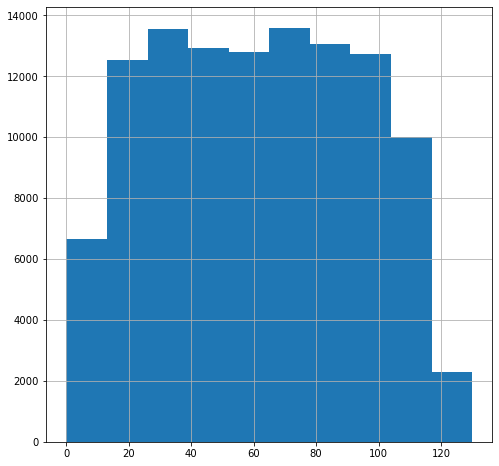

In [86]:
iqr_test('td', 0 , 130, 10)

Распределение нормальное, выбросов нет. 

## client_id - идентификатор клиента

Посмотрим как зависит id клиента от даты подачи заявки

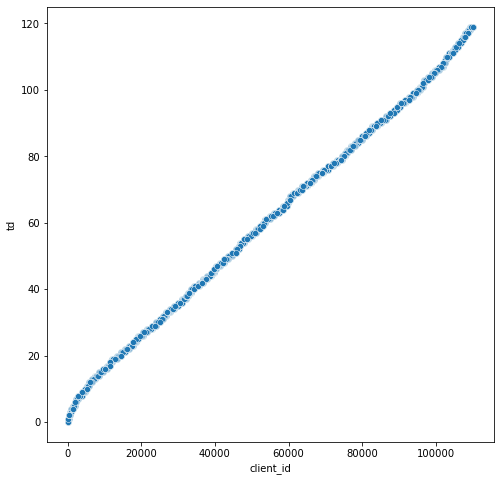

In [87]:
sns.scatterplot(x='client_id',y='td',data=df);

**client_id** - просто последовательная нумерация клиента, которую присваивали в день выдачи. Поэтому он полностью коррелируется с датой выдачи.  

In [88]:
df = df.drop(columns = ['app_date'])

## default - наличие дефолта  

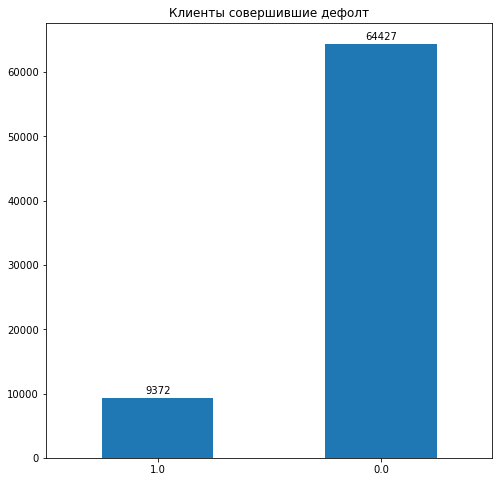

In [89]:
viz_counter_bar(df, 'default', 'Клиенты совершившие дефолт')

Примерно каждый 7й заемщик не возвращает кредит. 

## Оценка корреляций

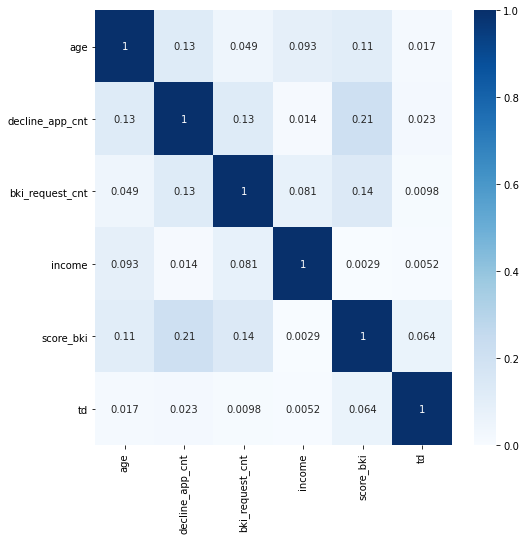

In [90]:
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki', 'td']
sns.heatmap(df[df.Train==1][num_cols].corr().abs(), annot=True, vmin=0, vmax=1, cmap='Blues');

Все признаки слабо скореллированы между собой, можно все взять в модель. 

# Feature Engeenering  
### Наличие автомобиля и иномарки  - car
В датасете присутвуют 2 бинарных признака (**car** и **car_type**) которые отвечают за наличие автомобиля и является этот автомобиль иномаркой или нет. Вместо двух признаков изменим тип признака **car** на категориальный: 0 - нет авто, 1 - есть автомобиль (не иномарка) 2 - иномарка

In [91]:
df.loc[df.car=='N', 'car'] = 0
df.loc[df.car=='Y', 'car'] = 1
df.loc[df.car_type=='Y', 'car'] = 2
df.drop(columns=['car_type'], inplace=True)

### Район проживания и работы work_ home_address

Тепловые карты, которые были построены ранее показывают, что признак как работа-проживание по районам больше влияет на доход и наличие авто, чем по отдельности. Создадим общий признак, который назовем work_home.

In [92]:
df.loc[df.work_address==1, 'work_address'] = 'w1'
df.loc[df.work_address==2, 'work_address'] = 'w2'
df.loc[df.work_address==3, 'work_address'] = 'w3'

df.loc[df.home_address==1, 'home_address'] = 'h1'
df.loc[df.home_address==2, 'home_address'] = 'h2'
df.loc[df.home_address==3, 'home_address'] = 'h3'

df['work_home'] = df['work_address'] + df['home_address']


Сгруппируем признаки по типу: бинарные, категриальные, числовые.  
**Бинарные** : пол(**sex**), наличие авто(**auto**), иномарка или нет(**car_type**), загран. паспорт(**foreign_passport**) и наличие хорошей работы(**good_work**)  
**Категориальные**: образование(**education**), категория домашнего и рабочего местоположения (**home_ work_address**), связь заемщика с клиентами банка(**sna**),
 давность наличиия информации о заемщике(**first_time**), рейтинг региона(**region_rating**)  
**Числовые**: возраст (**age**), количество отклонненные заявок(**decline_app_cnt**), запросы в БКИ(**bki_request_cnt**), доход(**income**), скоринговый балл БКИ(**score_bki**), кол-во дней со дня заявки(**td**)

In [100]:
bin_cols = ['sex', 'foreign_passport', 'good_work']
cat_cols = ['education', 'work_home', 'sna', 'first_time', 'region_rating', 'car']
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki', 'td']

### 7. Значимость непрерывных переменных по ANOVA F test

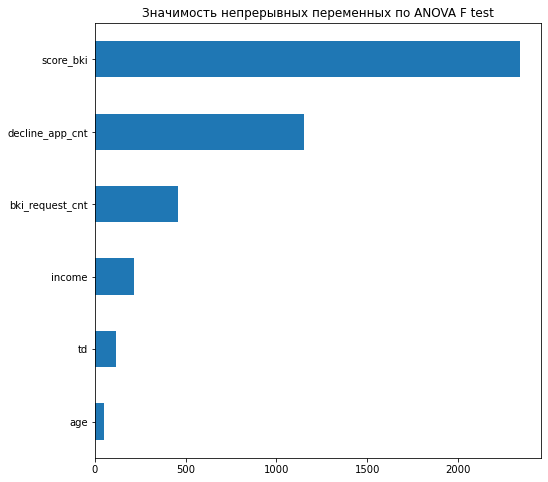

In [101]:
df_tr = df[df.Train==1]
imp_num = Series(f_classif(df_tr[num_cols], df_tr['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', title='Значимость непрерывных переменных по ANOVA F test');

Самый значимый из признаков - оценка плательщика БКИ (**score_bki**), далее количество запросов в БКИ (**bki_request_cnt**) и количество отказов (**decline_app_cnt**). Самый незначительный признак - возраст (**age**) заемщика и время со дня заявки (**td**) 

### 8. Категориальные переменные

In [102]:
df.education = df.education.astype(int)

In [103]:
label_encoder = LabelEncoder()
df['work_home'] = label_encoder.fit_transform(df['work_home'])

In [106]:
for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# убедимся в преобразовании    
df.head()

,client_id,education,sex,age,car,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,sna,first_time,foreign_passport,default,Train,td,work_home
0,25905,0,1,4.1431,2,0.0000,0,-2.0088,0.6931,50,9.7982,4,1,0,0.0000,1,31,3
1,63161,0,0,4.0943,0,0.0000,0,-1.5323,1.3863,50,9.8522,4,1,0,0.0000,1,70,7
2,25887,0,1,3.2581,1,1.0986,0,-1.4081,0.6931,80,10.3090,1,4,1,0.0000,1,31,3
3,16222,0,0,3.9890,0,0.0000,0,-2.0575,1.0986,50,9.2104,1,3,0,0.0000,1,22,7
4,101655,1,1,3.8918,0,0.0000,1,-1.2447,0.6931,60,10.3090,1,4,1,0.0000,1,107,7


#### Значимость категориальных переменных

Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.

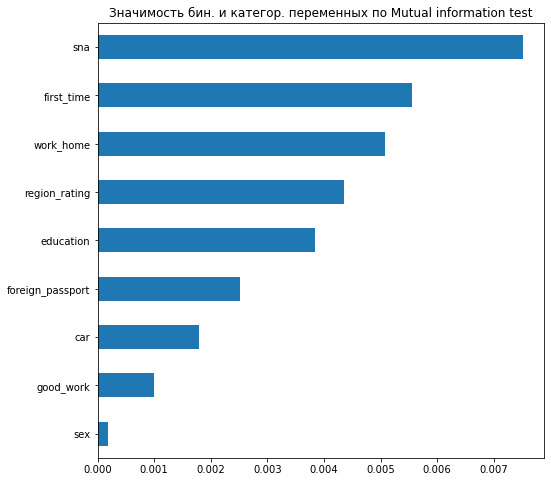

In [107]:
df_tr = df[df.Train==1]
imp_cat = Series(mutual_info_classif(df_tr[bin_cols + cat_cols], df_tr['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', title = 'Значимость бин. и категор. переменных по Mutual information test');

Самым значимым признаком оказалась свзяь заемщика с клиентами банка (**sna**) и давность наличия информации о заемщике (**first_time**)

### 9. Подготовка к машинному обучению

#### стандартизация числовых признаков

In [108]:
df.loc[df.Train==1, num_cols] = StandardScaler().fit_transform(df.query('Train==1')[num_cols].values)

In [109]:
df.loc[df.Train==0, num_cols] = StandardScaler().fit_transform(df.query('Train==0')[num_cols].values)

In [110]:
df=pd.get_dummies(df, prefix=cat_cols, columns=cat_cols)

## Построение модели

In [111]:
train = df.query('Train == 1').drop(['Train', 'client_id'], axis=1)
test = df.query('Train == 0').drop(['Train', 'client_id'], axis=1)

X = train.drop(['default'], axis=1)
y = train.default.values            

In [112]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [113]:
# проверяем
test.shape, train.shape, X.shape, X_train.shape, X_test.shape

((36349, 42), (73799, 42), (73799, 41), (59039, 41), (14760, 41))

## Логистическая регрессея

In [114]:
model = LogisticRegression(random_state=RANDOM_SEED, max_iter=100, solver='liblinear')

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

### 10. Оценка качества модели

In [115]:
print_metrics()

Accuracy: 0.8747
Precision: 0.3905
Recall: 0.0224
F1: 0.0424


## Матрица ошибок

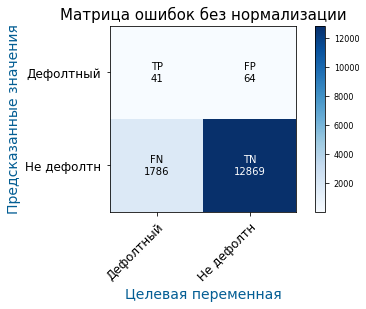

In [116]:
confusion_matrix_f(['Дефолтный','Не дефолтный'], y_test, y_pred, 1, normalize=False)

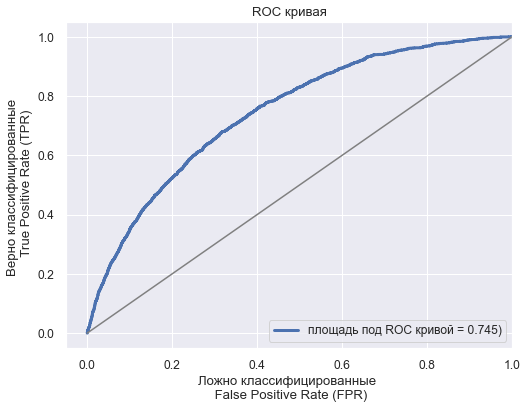

In [117]:
ROC_curve_with_area(y_test, y_pred_prob, 1.1)

## Precision-Recall кривая

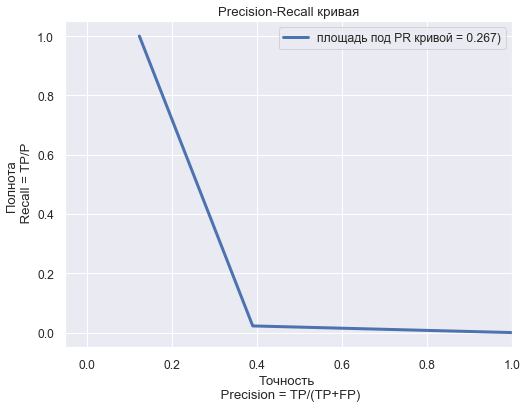

In [118]:
PR_curve_with_area(y_test, y_pred, 1.1)

## Кросс-валидация

In [119]:
temp_vec = cross_validate(model, X_test, y_test, cv=10, scoring='roc_auc', return_train_score=True);

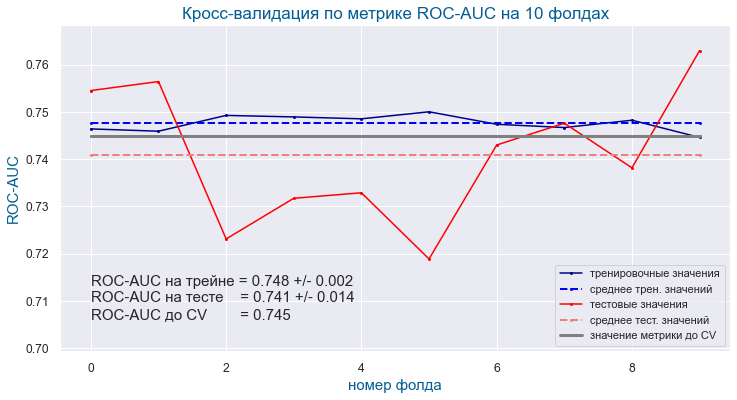

In [120]:
vis_cross_val_score('ROC-AUC', temp_vec, 0.744846, 1.1)

### 11. GridSearch

Запускаем на небольшом количестве итераций max_iter = 50 с достаточно большой дельтой останова tol1e-3

In [121]:
# запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой останова tol1e-3
# чтобы получить оптимальные параметры модели в первом приближении
model = LogisticRegression(random_state=RANDOM_SEED)

iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=12, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
    ##печатаем метрики
preds = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
print('Precision: %.4f' % precision_score(y_test, y_pred))
print('Recall: %.4f' % recall_score(y_test, y_pred))
print('F1: %.4f' % f1_score(y_test, y_pred))

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'none'
	random_state: 42
	solver: 'newton-cg'
	tol: 0.001
	verbose: 0
	warm_start: False
Accuracy: 0.6708
Precision: 0.2262
Recall: 0.6853
F1: 0.3401


Метрика **f1** подросла примерно в 9 раз. Построим модель на этих параметрах и посмотрим как это улучшит модель

In [122]:
model = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1, 
                           class_weight= 'balanced', 
                           dual= False, 
                           fit_intercept= True, 
                           intercept_scaling= 1, 
                           l1_ratio= None, 
                           multi_class= 'auto', 
                           n_jobs= 12, 
                           penalty= 'none', 
                           solver = 'newton-cg', 
                           verbose= 0, 
                           warm_start= False)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)
print_metrics()

Accuracy: 0.6708
Precision: 0.2262
Recall: 0.6853
F1: 0.3401


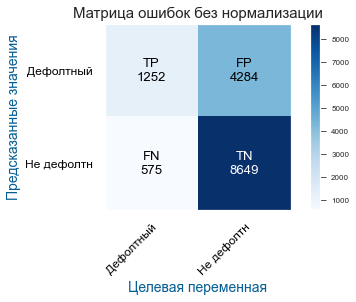

In [123]:
confusion_matrix_f(['Дефолтный','Не дефолтный'], y_test, y_pred, 1, normalize=False)

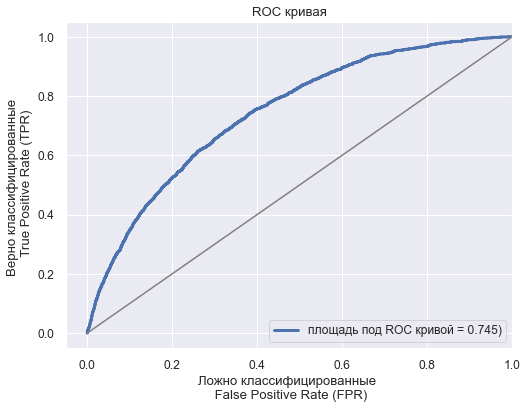

In [124]:
ROC_curve_with_area(y_test, y_pred_prob, 1.1)

## Precision-Recall кривая

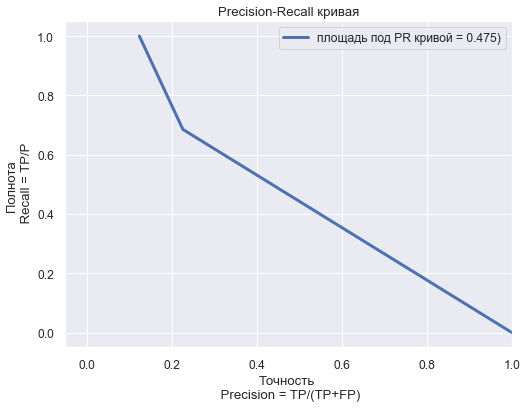

In [125]:
PR_curve_with_area(y_test, y_pred, 1.1)

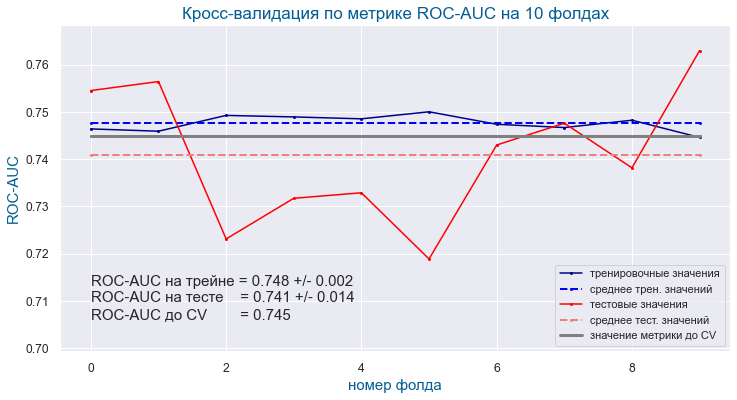

In [126]:
vis_cross_val_score('ROC-AUC', temp_vec, 0.744846, 1.1)

## Проверка нулевых коэффициентов при регуляризации первого порядка

In [127]:
# регуляризация первого порядка l1 позволяет оценить по нулевым или слишком низким коэффициентам признаки,
# которые не нравятся модели (в них могут быть выбросы или неподходящий формат)
# можно это поможет избавиться от большой дисперсии при кросс-валидации
model = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1, 
                           class_weight= 'balanced', 
                           dual= False, 
                           fit_intercept= True, 
                           intercept_scaling= 1, 
                           l1_ratio= None, 
                           multi_class= 'auto', 
                           n_jobs= None, 
                           penalty= 'l1', 
                           solver = 'liblinear', 
                           verbose= 0, 
                           warm_start= False)

model.fit(X_train, y_train)

display(model_coef(X_train.columns, model.coef_[0]))

,имя признака,коэффициент модели
0,work_home_2,-2.2588
1,region_rating_80,-0.8727
2,work_home_1,-0.8102
3,education_4,-0.7650
4,region_rating_20,0.5659
5,region_rating_70,-0.5319
6,education_3,-0.5237
7,work_home_7,0.4862
8,score_bki,0.4856
9,region_rating_30,0.4661


Часть признаков совсем не влияет на итоговые результаты, список на удлаение:  
'first_time_1', 'sna_2', 'work_home_8', 'education_2', 'car_0', 'car_1', 
'income', 'region_rating_50', 'age', 'sna_3'


In [131]:
drop_list1 = ['first_time_1', 'sna_2', 'work_home_8', 'education_2', 'car_0', 'car_1', 
              'income', 'region_rating_50', 'age', 'sna_3']

In [132]:
train = df.query('Train == 1').drop(['Train', 'client_id']+drop_list1, axis=1)
test = df.query('Train == 0').drop(['Train', 'client_id']+drop_list1, axis=1)

X = train.drop(['default'], axis=1)
y = train.default.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

## Проверка качества модели после удаления признаков

In [133]:
model = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1, 
                           class_weight= 'balanced', 
                           dual= False, 
                           fit_intercept= True, 
                           intercept_scaling= 1, 
                           l1_ratio= None, 
                           multi_class= 'auto', 
                           n_jobs= -1, 
                           penalty= 'none', 
                           solver = 'newton-cg', 
                           verbose= 0, 
                           warm_start= False)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
print('Precision: %.4f' % precision_score(y_test, y_pred))
print('Recall: %.4f' % recall_score(y_test, y_pred))
print('F1: %.4f' % f1_score(y_test, y_pred))

Accuracy: 0.6715
Precision: 0.2273
Recall: 0.6891
F1: 0.3418


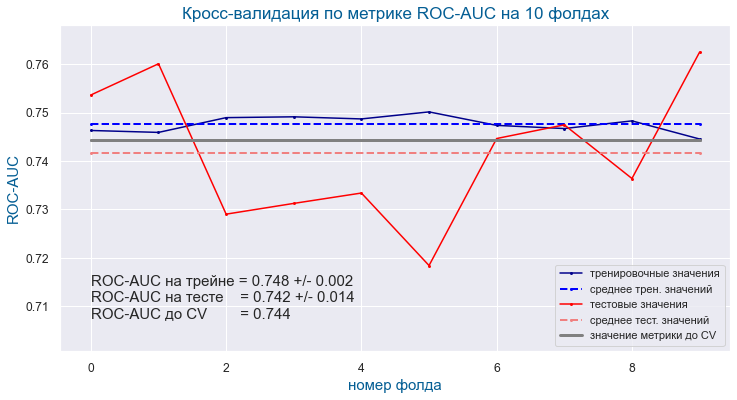

In [134]:
temp_vec = cross_validate(model, X_test, y_test, cv=10, scoring='roc_auc', return_train_score=True)
vis_cross_val_score('ROC-AUC', temp_vec, 0.744262, 1.1)

Удаление нескольких признаков со значениями около 0.000 незначительно улучшило метрики. 

## Поиск оптимальных параметров модели. GridSearchCV(2)

In [184]:
# блок поиска параметров закомментирован потому что он выполняется очень долго, ниже модель использует оптимальные параметры 

# Не забудь ВКЛЮЧИТЬ OC = 4000 !!!

model = LogisticRegression(multi_class = 'ovr', class_weight='balanced', random_state=RANDOM_SEED)

param_grid = [
     {'penalty': ['l1'], 'C':np.logspace(0, 4, 10), 'max_iter':[2000],'tol':[1e-5], 'solver':['liblinear', 'saga']},
     #{'penalty': ['l2'], 'C':np.logspace(0, 4, 10), 'max_iter':[1000],'tol':[1e-5], 'solver':['newton-cg', 'lbfgs', 'sag', 'saga']},
     {'penalty': ['none'], 'max_iter':[1000],'tol':[1e-5], 'solver':['sag', 'newton-cg']},
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=12, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_

#C = np.logspace(0, 3, 20)
#[0.01, 1, 100]
##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

        ##печатаем метрики
preds = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1: %.4f' % f1_score(y_test, preds))

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 2000
	multi_class: 'ovr'
	n_jobs: None
	penalty: 'l1'
	random_state: 42
	solver: 'saga'
	tol: 1e-05
	verbose: 0
	warm_start: False
Accuracy: 0.6711
Precision: 0.2264
Recall: 0.6853
F1: 0.3403


In [185]:
# третья модель
model = LogisticRegression(C=2.15, 
                           penalty='l1', 
                           multi_class = 'ovr', 
                           class_weight='balanced', 
                           solver='saga', 
                           random_state=RANDOM_SEED,
                           max_iter = 2000)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

preds = model.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1: %.4f' % f1_score(y_test, preds))

Accuracy: 0.6714
Precision: 0.2266
Recall: 0.6858
F1: 0.3407


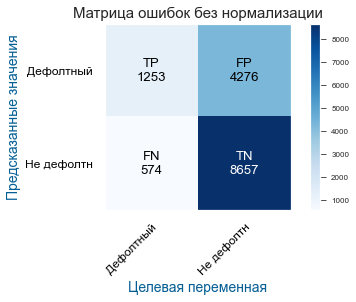

In [186]:
confusion_matrix_f(['Дефолтный','Не дефолтный'], y_test, y_pred, 1, normalize=False)

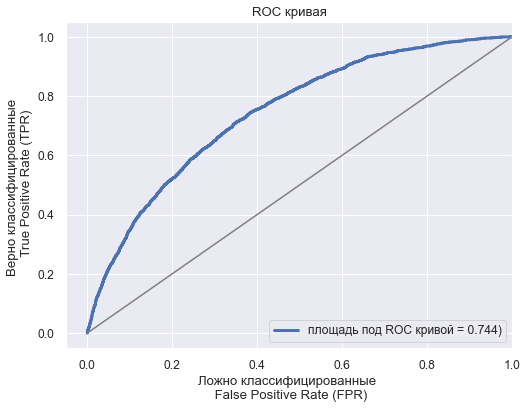

In [187]:
ROC_curve_with_area(y_test, y_pred_prob, 1.1)

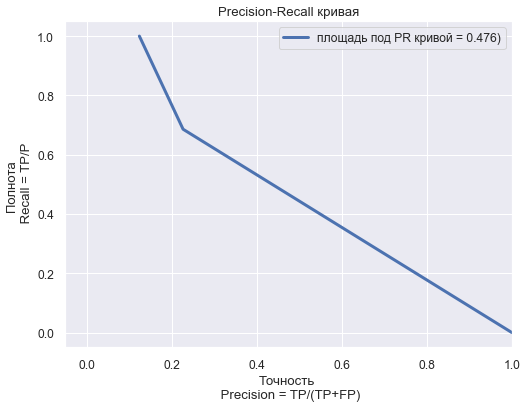

In [188]:
PR_curve_with_area(y_test, y_pred, 1.1)

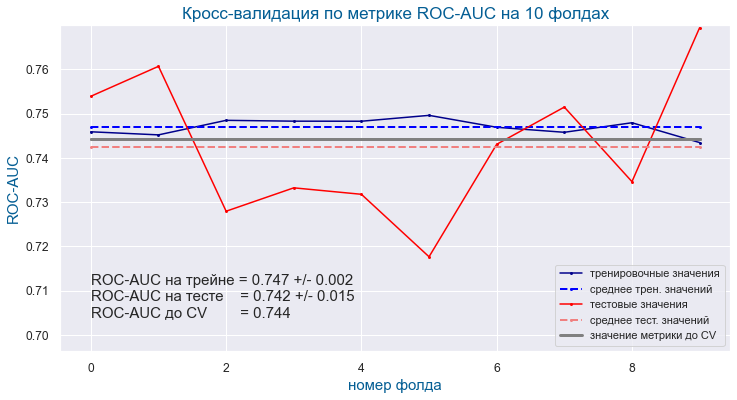

In [189]:
temp_vec = cross_validate(model, X_test, y_test, cv=10, scoring='roc_auc', return_train_score=True)
vis_cross_val_score('ROC-AUC', temp_vec, 0.744262, 1.1)

## SUBMISSION

In [190]:
train = df.query('Train == 1').drop(['Train', 'client_id']+drop_list1, axis=1)
test = df.query('Train == 0').drop(['Train', 'client_id']+drop_list1, axis=1)

In [191]:
X_train=train.drop(['default'], axis=1)
y_train = train.default.values
X_test = test.drop(['default'], axis=1)

In [192]:
# проверяем
test.shape, train.shape, X_train.shape, y_train.shape, X_test.shape

((36349, 32), (73799, 32), (73799, 31), (73799,), (36349, 31))

In [194]:
model = LogisticRegression(C=2.15, 
                           penalty='l1', 
                           multi_class = 'ovr', 
                           class_weight='balanced', 
                           solver='saga', 
                           random_state=RANDOM_SEED,
                           max_iter = 2000)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]

In [158]:
submit = pd.DataFrame(df_test.client_id)
submit['default']=y_pred_prob
submit.to_csv('submission.csv', index=False)

### Лучший результат 0.73744